Attribute Information:

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels. 


Source:
  http://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise#

In [35]:
import pandas as pd
import numpy as np
import feather

from statsmodels.formula.api import ols
from scipy.stats import f as fisher

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
%time
#Load data
Header = ["Freq", "AngleAttach", "ChordLength", "FstreamVelo", "Suction", "SoundPress"]
airfoil = pd.read_csv("../../datasets/Regression/Airfoil-Self-Noise/airfoil_self_noise.dat", sep="\t", names = Header)
            

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [36]:
#Testing Feather
feather.write_dataframe(airfoil, "../../datasets/Regression/Airfoil-Self-Noise/airfoil_self_noise.feather")

%time
pd.read_feather("../../datasets/Regression/Airfoil-Self-Noise/airfoil_self_noise.feather")

In [26]:
#General Desc
airfoil.describe().T

,count,mean,std,min,25%,50%,75%,max
Freq,1503.0,2886.380572,3152.573137,200.000000,800.000000,1600.000000,4000.000000,20000.000000
AngleAttach,1503.0,6.782302,5.918128,0.000000,2.000000,5.400000,9.900000,22.200000
ChordLength,1503.0,0.136548,0.093541,0.025400,0.050800,0.101600,0.228600,0.304800
FstreamVelo,1503.0,50.860745,15.572784,31.700000,39.600000,39.600000,71.300000,71.300000
Suction,1503.0,0.011140,0.013150,0.000401,0.002535,0.004957,0.015576,0.058411
SoundPress,1503.0,124.835943,6.898657,103.380000,120.191000,125.721000,129.995500,140.987000


# A. Detect Outliers

## 1.1 Univariate Approach (Interquartile Range)
  - Plot Boxplot for each attribute
  - Search for all observations below Q1 - 1.5 x Q1
  - Searcg for all obervations above Q3 + 1.5 Q3

In [28]:
#Compute interquartile
description = airfoil.describe().T
IQR = description["75%"]-description["25%"]
IQR

Freq           3200.000000
AngleAttach       7.900000
ChordLength       0.177800
FstreamVelo      31.700000
Suction           0.013041
SoundPress        9.804500
dtype: float64

### Lower 1.5xIQR whisker

In [30]:
# Lower bound whiskers
LowerWhisker = description["25%"]-IQR*1.5
LowerWhisker

Freq          -4000.000000
AngleAttach      -9.850000
ChordLength      -0.215900
FstreamVelo      -7.950000
Suction          -0.017026
SoundPress      105.484250
dtype: float64

#### Notice that all values are negative or all variables are positive. So we should expect a right skewed distributions of the variables.

### Upper 1.5xIQR whisker

In [31]:
# Upper bound whiskers
Upperwhisker = description["75%"] + 1.5*IQR

Upperwhisker

Freq           8800.000000
AngleAttach      21.750000
ChordLength       0.495300
FstreamVelo     118.850000
Suction           0.035137
SoundPress      144.702250
dtype: float64

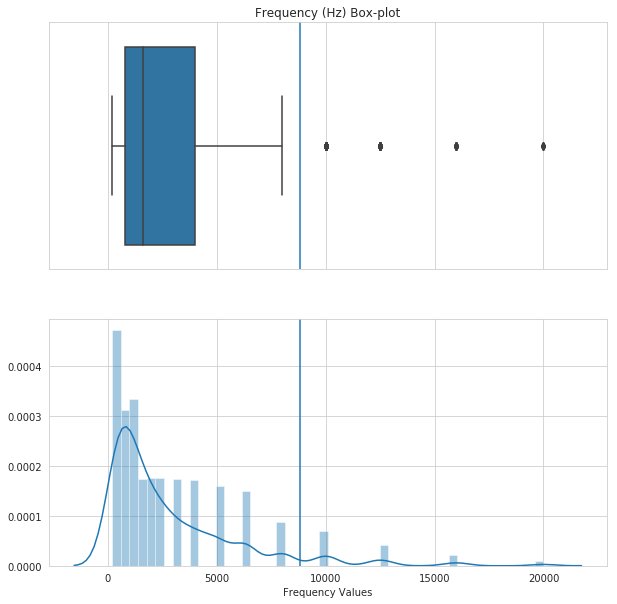

In [96]:
#Frequency
f, (axes1, axes2) = plt.subplots(2, 1,figsize = (10,10), sharex=True)
sns.set_style("whitegrid")
sns.boxplot(x = 'Freq', data = airfoil, orient="h", ax = axes1)
sns.distplot(airfoil['Freq'], bins=50, ax = axes2)
axes1.set_title("Frequency (Hz) Box-plot")
axes1.set_xlabel(" ")
axes2.set_title("")
axes2.set_xlabel("Frequency Values")

#Add Upper Bound whiskers
axes1.axvline(Upperwhisker["Freq"])
axes2.axvline(Upperwhisker["Freq"])

### After inspecting each attributes, it's better to exclude observations that have similar values. But for the moment we will be just inspecting outliers later on in the modeling phase we can remove them and check how the model perform withour these values.

In [78]:
#Get Observation less or bigger than 1.5xWhiskers bound
airfoil.loc[airfoil["Freq"] > Upperwhisker["Freq"] , "Freq"].shape[0]/airfoil.shape[0]

0.057218895542248835

### What happens if we remove observations identified with outliers attributes?

In [88]:
#Drop observations with outliers
ObswithOutl = airfoil.loc[airfoil["Freq"] > Upperwhisker["Freq"] ,:]

In [92]:
#Df dropped outliers
dfdropOut = airfoil.drop(ObswithOutl.index)

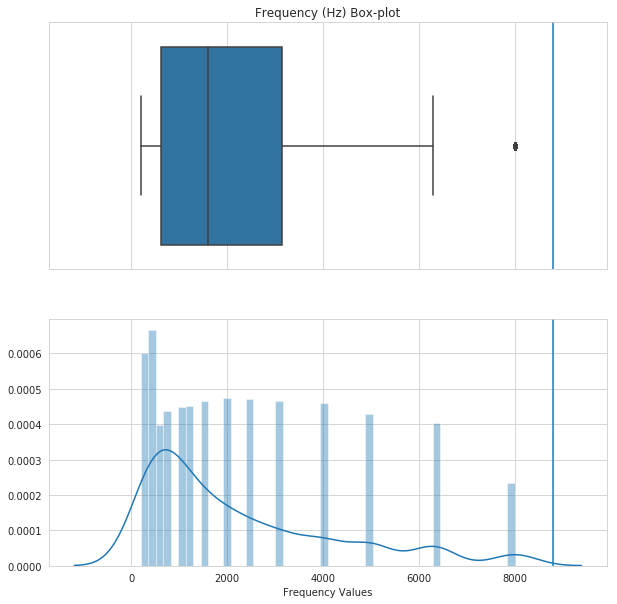

In [95]:
#Frequency
f, (axes1, axes2) = plt.subplots(2, 1,figsize = (10,10), sharex=True)
sns.set_style("whitegrid")
sns.boxplot(x = 'Freq', data = dfdropOut, orient="h", ax = axes1)
sns.distplot(dfdropOut['Freq'], bins=50, ax = axes2)
axes1.set_title("Frequency (Hz) Box-plot")
axes1.set_xlabel(" ")
axes2.set_title("")
axes2.set_xlabel("Frequency Values")

#Add Upper Bound whiskers
axes1.axvline(Upperwhisker["Freq"])
axes2.axvline(Upperwhisker["Freq"])

#### Density curve becomes flatter, we can repeat the process mutliple time until we get density curve that look like a normal distribution.

#### Only 5% of current observations has Frequency identified as outliers. But what about other attribute?

In [83]:
#Frequency of observations bigger than 1.5xWhiskers bound
print("Frequency of observations bigger than 1.5xWhiskers bound.\n")
for col in airfoil.columns.tolist():
    freq = airfoil.loc[airfoil[col] > Upperwhisker[col] ,:].shape[0]/airfoil.shape[0] *100
    print("Outliers frequency is {} in {}".format(round(freq,2), col))

Frequency of observations bigger than 1.5xWhiskers bound.

Outliers frequency is 5.72 in Freq
Outliers frequency is 2.0 in AngleAttach
Outliers frequency is 0.0 in ChordLength
Outliers frequency is 0.0 in FstreamVelo
Outliers frequency is 8.25 in Suction
Outliers frequency is 0.0 in SoundPress


In [85]:
#Frequency of observations less than 1.5xWhiskers bound
print("Frequency of observations less than 1.5xWhiskers bound.\n")
for col in airfoil.columns.tolist():
    freq = airfoil.loc[airfoil[col] < LowerWhisker[col] ,:].shape[0]/airfoil.shape[0] *100
    print("Outliers frequency is {} in {}".format(round(freq,2), col))

Frequency of observations less than 1.5xWhiskers bound.

Outliers frequency is 0.0 in Freq
Outliers frequency is 0.0 in AngleAttach
Outliers frequency is 0.0 in ChordLength
Outliers frequency is 0.0 in FstreamVelo
Outliers frequency is 0.0 in Suction
Outliers frequency is 0.27 in SoundPress


## 1.2 Clip out bottom and top
   - If we are uncertain about an appropriate range
   - Remove values that belongs to the upper and bottom 1% of probability distribution
   - Values not in the interval will be transformed to the min or max of the interval

Text(0,0.5,'Num Apts at that price')

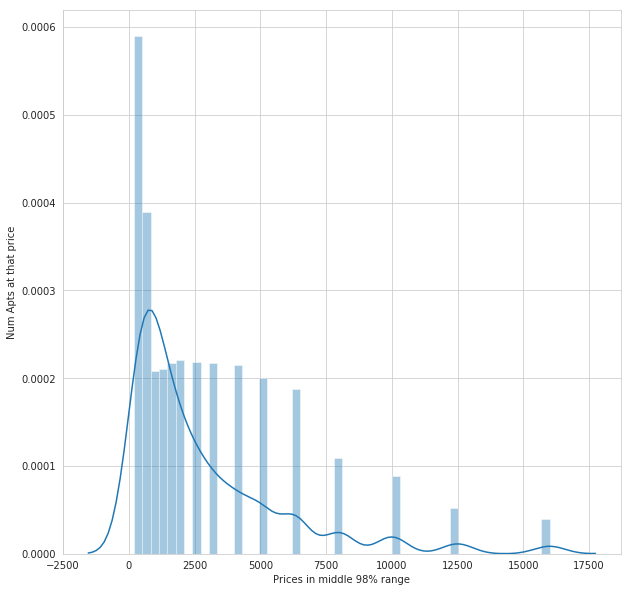

In [18]:
#Find middle 98% of frequencies
upper, lower = np.percentile(airfoil.Freq, [1, 99])

clipped = np.clip(airfoil.Freq, upper, lower)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (10,10))
sns.distplot(clipped, bins=50)
ax.set_xlabel('Prices in middle 98% range')
ax.set_ylabel('Num Apts at that price')

### 1.3 Numerical Transformation
   - Taking the log of a predictor or target variable is useful when there are outliers that can't be filtered out because they are important to the model
   - Easy to execute
   - Understanding why taking the numerical transformation of the target variable works and how it affects the training/testing process is intellectually challenging
   - We can get a nice normally-shaped distribution without having to clip outliers
   - Log because can transforms a skewed distribution to a normal distribution

Text(0.5,0,'Frequency Values')

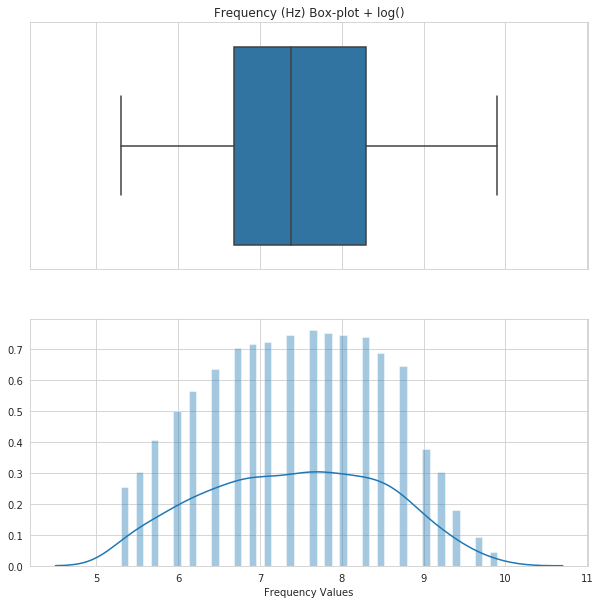

In [33]:
#Frequency
f, (axes1, axes2) = plt.subplots(2, 1,figsize = (10,10), sharex=True)
sns.set_style("whitegrid")
sns.boxplot(airfoil.Freq.apply(np.log), orient="h", ax = axes1)
sns.distplot(airfoil.Freq.apply(np.log), bins=50, ax = axes2)
axes1.set_title("Frequency (Hz) Box-plot + log()")
axes1.set_xlabel(" ")
axes2.set_title("")
axes2.set_xlabel("Frequency Values")


### A numerical transformation on Frequencies values seems to be the proper transformation, because we are getting symetric distribution (i.e pereferable situation). The reason why this transformation is good here, because there can be wide difference between frequencies values, some frequencies values can be very high a log here seems to zoom out . We are zooming to make the long tail more apparent. Averages are highly sensitive to outliers.

## 2. Multivariate Approach
  - Limited to multiple linear regression
  - Computes effect of deleting a given observation
  - Choose a cut-off values to use for spotting highly influential points
      - Median point $${\displaystyle F_{0.5}(p,n-p)}$$ can be used as a cut-off, where n number of samples, p number of attributes and F(,) Fisher distribution.
      - Previous value is close to 1 for large n, simple operational guideline of Cook Distabce >1 has been suggested.
      - Observations that have a cook’s distance greater than 4 times the mean may be classified as influential

In [101]:
columns = airfoil.columns.tolist()

In [106]:
#Regression model
m = ols('SoundPress' + '~' + "+".join(columns[:-1]), airfoil).fit()
#Compute cook distance
infl = m.get_influence()
sm_fr = infl.summary_frame()

Text(1603,0.00313957,'Mean Cook Dist*4')

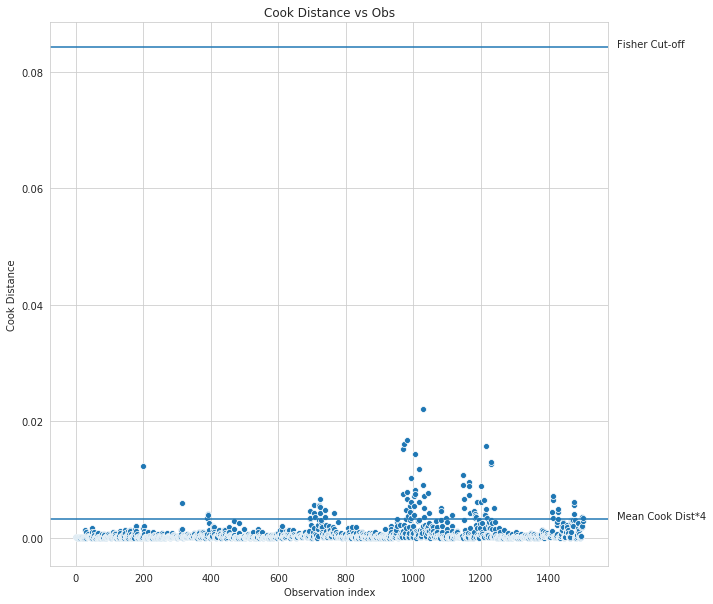

In [142]:
#Plot Cook distance
f, axes1 = plt.subplots(figsize = (10,10))
sns.set_style("whitegrid")
sns.scatterplot(x = range(sm_fr.shape[0]), y = sm_fr["cooks_d"])
axes1.set_title("Cook Distance vs Obs")
axes1.set_xlabel("Observation index")
axes1.set_ylabel("Cook Distance")

#Add Fisher cuttoff
fisherCut = fisher.cdf(0.5,sm_fr.shape[1], sm_fr.shape[0]-sm_fr.shape[1])
axes1.axhline(fisherCut)
axes1.text(y = fisherCut, x=sm_fr.shape[0]+100, s = "Fisher Cut-off")

axes1.axhline(sm_fr["cooks_d"].mean()*4)
axes1.text(y=sm_fr["cooks_d"].mean()*4, x=sm_fr.shape[0]+100, s = "Mean Cook Dist*4")

### No cook distance greater than cut-off value or 1. Note that the Cook's distance measure does not always correctly identify influential observations. If you inspect the row one by one it is likely that one of the X variables (inputs) included in the model had extreme values. But we have more than 80 row, what to do ?

In [146]:
#Get observation index where CooK Dist > CookDist.mean*4
cuttoff = sm_fr["cooks_d"].mean()*4
#Obs index
cookdropOut = sm_fr[sm_fr["cooks_d"] > cuttoff].index

dfdropCook = airfoil.drop(cookdropOut)

### Inspect the influence of outlier removal on multiple linear regression models.

In [155]:
#Build MLR models
xtr, xtst, ytr, ytst = train_test_split(airfoil.drop("SoundPress", 1), airfoil["SoundPress"], test_size = 0.25)

#Droped influential obs (Cook Dist)
ycooktr, ycooktst, xcooktr, xcooktst = train_test_split(dfdropCook["SoundPress"], dfdropCook.drop("SoundPress", 1), test_size = 0.25)

In [157]:
#
mlrObj = LinearRegression(normalize=True)
#General model
model = mlrObj.fit(xtr, ytr)
yhat = model.predict(xtst)

#Cook model
cookmodel = mlrObj.fit(xcooktr, ycooktr)
yhatcook = model.predict(xcooktst)

Text(0,0.5,'Y hat')

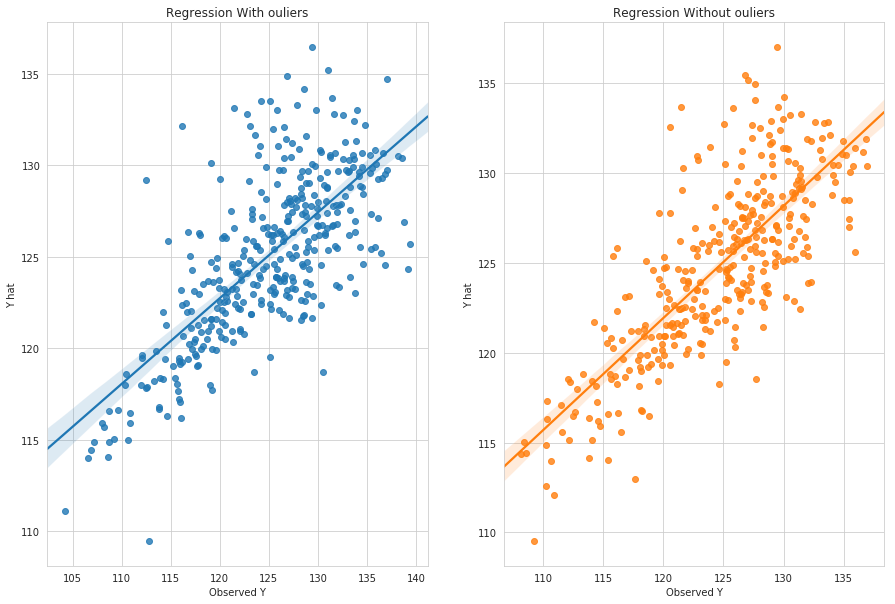

In [165]:
#Plot regression
f, (axes1, axes2) = plt.subplots(1,2, figsize=(15,10))
sns.regplot(ytst, yhat, ax= axes1)
sns.regplot(ycooktst, yhatcook, ax = axes2)

axes1.set_title("Regression With ouliers")
axes1.set_xlabel("Observed Y")
axes1.set_ylabel("Y hat")
axes2.set_title("Regression Without ouliers")
axes2.set_xlabel("Observed Y")
axes2.set_ylabel("Y hat")

#### It's ambiguous if any improvement occured or something changed. It's better to put them on the graph.

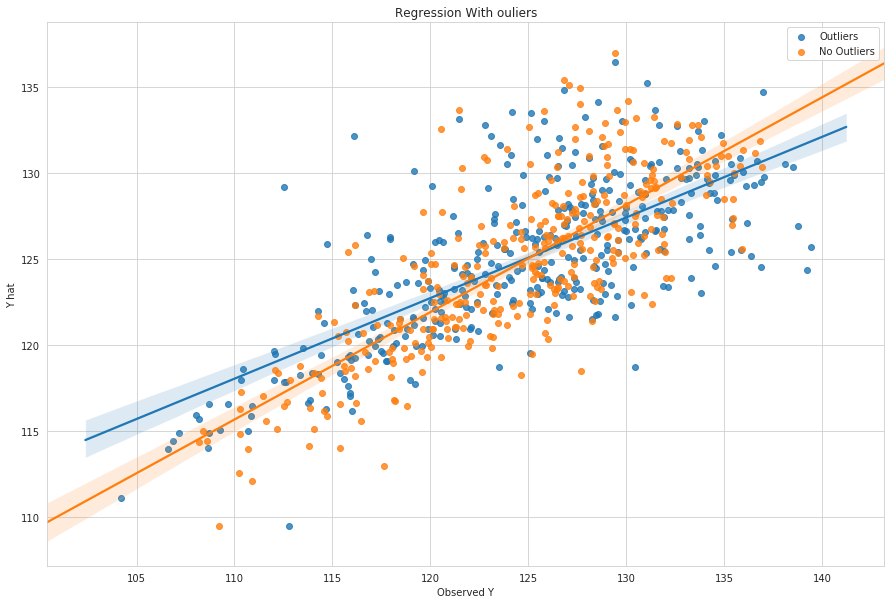

In [168]:
#
f, axes1 = plt.subplots(figsize=(15,10))
sns.regplot(ytst, yhat, ax= axes1, label = "Outliers")
sns.regplot(ycooktst, yhatcook, ax = axes1, label = "No Outliers")

axes1.set_title("Regression With ouliers")
axes1.set_xlabel("Observed Y")
axes1.set_ylabel("Y hat")
axes1.legend()